##### import sys

sys.path.append("/kaggle/input/pretrained-models-pytorch")
sys.path.append("/kaggle/input/efficientnet-pytorch")
sys.path.append("/kaggle/input/smp-github/segmentation_models.pytorch-master")

In [1]:
!pip uninstall -y timm

Found existing installation: timm 1.0.9
Uninstalling timm-1.0.9:
  Successfully uninstalled timm-1.0.9


In [2]:
!mkdir /kaggle/working/einops
!cp -r /kaggle/input/einops/einops-master /kaggle/working/einops
!pip install /kaggle/working/einops/einops-master

Processing ./einops/einops-master
  Preparing metadata (setup.py) ... - done
  Created wheel for einops: filename=einops-0.4.1-py3-none-any.whl size=31100 sha256=4ac7cfed4c4cfb9e738146c3796a1d7cec8eacc675a7ae2cd8479da9e2498f0b
  Stored in directory: /root/.cache/pip/wheels/f2/96/0e/7b178ba95ce447f0cee3ccd07b9c2ba1b4fd109a80737cbbf2
Successfully built einops


In [3]:
import sys

sys.path.append("/kaggle/input/pretrained-models-pytorch/") 
sys.path.append("/kaggle/input/efficientnet-pytorch/") 
sys.path.append("/kaggle/input/smp-github/segmentation_models.pytorch-master/")
sys.path.append("/kaggle/input/timm1-0-4-dev0/pytorch-image-models-main/")

In [4]:
import segmentation_models_pytorch as smp

/kaggle/input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [5]:
print(smp.__version__)

0.3.3


In [6]:
import timm
print(timm.__version__)

1.0.10.dev0


In [7]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
# from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import glob
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import dice
from torch.optim import Adam, SGD, AdamW, lr_scheduler
from timm.optim import create_optimizer_v2
import datetime

In [8]:
# import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [9]:
# CPMP: declare the two GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [10]:
# np.arange(0, 5, 0.5)
# # np.arange(-3, 3, 0.5)

In [11]:
# data = np.random.randint(25,100,10)

In [12]:
# np.quantile(data,np.arange(0,1+1/2,1/2))

In [13]:
import warnings

warnings.filterwarnings("ignore")

In [14]:
class CFG:
    # ============== comp exp name =============/kaggle/input/contrails-images-ash-color/
    comp_name = 'Hacking_vasculature'

    # comp_dir_path = './'
    comp_dir_path = '/kaggle/input/'
    data_path = '/kaggle/input/blood-vessel-segmentation'
    comp_folder_name = 'blood-vessel-segmentation'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    train_df = '/kaggle/input/blood-vessel-segmentation/train_rles.csv'
    exp_name = 'blood-vessel-segmentation'
    mode = ['train','valid']
    # ============== pred target =============
    target_size = 1
    TH = 0.5
    augment_type = 'rotation'
    augment_prob = 0.95
    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'coat_lite_small'
#     backbone = 'resnet50.b2k_in1k'
    encoder_weights="imagenet"
    decoder_channels = [512,256, 128, 64, 32]
    dropout = 0.0
    activation = None
    in_chans = 1 # 65
    drop_rate = 0.
    drop_path_rate = 0.05
    # ============== training cfg =============
    origin_size = 256
    size = 512
    tile_size = 384
    stride = tile_size // 8

    train_batch_size = 2 # 32
    valid_batch_size = 2
    use_amp = True
    LR_SCHEDULER = "CosineAnnealingLR"
#     scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4
    max_lr = 5e-4
    smooth = 0.01
    # ============== fold =============
    fold = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'
    T_0 = 1
    T_mult = 2
    T_max = 1
    min_lr = 5e-6
    weight_decay = 1e-6
    max_grad_norm = 10

    print_freq = 50
    num_workers = 2
    device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seed = 2024

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'/kaggle/working/outputs/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

set dataset path


In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [17]:
class dotdict(dict):
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

	def __getattr__(self, name):
		try:
			return self[name]
		except KeyError:
			raise AttributeError(name)

In [18]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)
        
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [19]:
cfg_init(CFG)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


In [20]:
# ============== augmentation =============
train_aug_list = [
    # A.RandomResizedCrop(
    #     size, size, scale=(0.85, 1.0)),
#     A.ChannelShuffle(p=0.5),
#     A.ChannelDropout(p=0.5)
#     A.Resize(CFG.size,CFG.size, interpolation=cv2.INTER_LINEAR),
#     A.HorizontalFlip(p=0.1),
    A.RandomRotate90(p=1.),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.3),
    A.VerticalFlip(p=0.3),
#     A.OneOf([
#             A.RandomRotate90(p=0.5),
#             A.Rotate(limit=15),
#     ],p=0.5),
    A.RandomResizedCrop(height=CFG.size,width=CFG.size,scale=(0.75,1.),ratio=(0.9,1.1111),
                        interpolation=cv2.INTER_LINEAR,p=0.3),
#     A.OneOf([
#         A.Affine(scale={'x':(0.75,1.25),'y':(0.85,1.15)},
#                  translate_percent={'x':(0.,0.15),'y':(0.,0.15)},
#                  shear={'x':(-20,20),'y':(-15,15)},interpolation=cv2.cv2.INTER_LINEAR,p=0.75),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.35, rotate_limit=0., p=0.25),
#     ],p=0.5),

#     A.OneOf([
#         A.RandomBrightnessContrast(p=1.),
# #         A.HueSaturationValue(p=0.5),
#     ], p=0.3),
    
#     A.GaussNoise(var_limit=(10.0, 30.0),p=0.15),
#     A.OneOf([
#         A.GridDistortion(num_steps=5, distort_limit=0.025, p=0.3),
#         A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3),
#         A.ElasticTransform(alpha=1, sigma=50, alpha_affine=25, p=0.4)
#     ], p=0.15),
# #     A.MaskDropout(max_objects=(0,5),p=0.5),
#     A.OneOf([
#             A.GridDropout(always_apply=False, p=.5, ratio = .25, unit_size_min = 20, 
#                             unit_size_max = 60, holes_number_x=30, holes_number_y=30),
#             A.CoarseDropout(always_apply=False, p=.5, max_holes=40, max_height=CFG.size//10,
#                               max_width=CFG.size//10, min_holes=10, min_height=CFG.size//40, min_width=CFG.size//40, 
#                               mask_fill_value=None,fill_value=0)], p=0.5),
#     A.CoarseDropout(max_holes=20, max_height=CFG.size//10, max_width=CFG.size//10,
#                      min_holes=10, fill_value=0, mask_fill_value=0, p=0.5),
#     A.OneOf([
# #         A.HueSaturationValue(10,15,10),
# #             A.CLAHE(clip_limit=2),
#         A.RandomBrightnessContrast(),            
#     ], p=0.15),
    # A.Cutout(max_h_size=int(size * 0.6),
    #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#     A.Normalize(
#         mean= [0] *CFG.in_chans,
#         std= [1] * CFG.in_chans
#     ),
#     ToTensorV2(transpose_mask=True),
]

valid_aug_list = [
    A.Resize(CFG.size, CFG.size),
    A.Normalize(
        mean= [0] * CFG.in_chans,
        std= [1] * CFG.in_chans
    ),
    ToTensorV2(transpose_mask=True),
]

# Augmentation
def augmentation(aug: str):
    if aug == 'd4':  # Dihedral group D4
        return A.Compose([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=0.5),
        ])
    elif aug == 'rotation':
        return A.Compose([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(rotate_limit=30, scale_limit=0.2, p=0.75)
        ])
    else:
        raise ValueError

In [21]:
def get_transforms(data):
    if data == 'train':
        aug = A.Compose(train_aug_list)
    elif data == 'valid':
        aug = A.Compose(valid_aug_list)

    # print(aug)
    return aug

In [22]:
#-----
def file_to_id(f):
    s = f.split('/')
    return s[-3]+'_' + s[-1][:-4]

In [23]:
mode = CFG.mode # 'local' #
data_dir = CFG.comp_dataset_path

In [24]:
# class dotdict(dict):
#     """
#     a dictionary that supports dot notation 
#     as well as dictionary access notation 
#     usage: d = DotDict() or d = DotDict({'val1':'first'})
#     set attributes: d.val2 = 'second' or d['val2'] = 'second'
#     get attributes: d.val2 or d['val2']
#     """
#     __getattr__ = dict.__getitem__
#     __setattr__ = dict.__setitem__
#     __delattr__ = dict.__delitem__

#     def __init__(self, dct):
#         for key, value in dct.items():
#             if hasattr(value, 'keys'):
#                 value = dotdict(value)
#             self[key] = value

In [25]:
if 'train' in mode:
    train_folder = [
        ('kidney_1_dense', (0, 2278+1)),
        #('kidney_1_dense', (0, 1000+1)),
    ] #debug for local development
    
    train_meta = []
    for image_folder, image_no in train_folder:
        file = [f'{data_dir}/train/{image_folder}/images/{i:04d}.tif' for i in range(*image_no)]
        H,W = cv2.imread(file[0],cv2.IMREAD_GRAYSCALE).shape
        train_meta.append(dict(
            name  = image_folder,
            file  = file,
            shape = (len(file), H, W),
            id = [file_to_id(f) for f in file],
        ))
        
if 'valid' in mode:
    valid_folder = [
        ('kidney_3_sparse', (496, 496+500+1)),
        #('kidney_1_dense', (0, 1000+1)),
    ] #debug for local development
    
    valid_meta = []
    for image_folder, image_no in valid_folder:
        file = [f'{data_dir}/train/{image_folder}/images/{i:04d}.tif' for i in range(*image_no)]
        H,W = cv2.imread(file[0],cv2.IMREAD_GRAYSCALE).shape
        valid_meta.append(dict(
            name  = image_folder,
            file  = file,
            shape = (len(file), H, W),
            id = [file_to_id(f) for f in file],
        ))

In [26]:
print('len(train_meta) :', len(train_meta[0]))
print(train_meta[0]['file'][:3])

print('len(valid_meta) :', len(valid_meta[0]))
print(valid_meta[0]['file'][:3])

len(train_meta) : 4
['/kaggle/input/blood-vessel-segmentation//train/kidney_1_dense/images/0000.tif', '/kaggle/input/blood-vessel-segmentation//train/kidney_1_dense/images/0001.tif', '/kaggle/input/blood-vessel-segmentation//train/kidney_1_dense/images/0002.tif']
len(valid_meta) : 4
['/kaggle/input/blood-vessel-segmentation//train/kidney_3_sparse/images/0496.tif', '/kaggle/input/blood-vessel-segmentation//train/kidney_3_sparse/images/0497.tif', '/kaggle/input/blood-vessel-segmentation//train/kidney_3_sparse/images/0498.tif']


In [27]:
def norm_by_percentile(volume, low=10, high=99.8, alpha=0.01):
    xmin = np.percentile(volume,low)
    xmax = np.percentile(volume,high)
    x = (volume-xmin)/(xmax-xmin)
    if 1:
        x[x>1]=(x[x>1]-1)*alpha +1
        x[x<0]=(x[x<0])*alpha
    #x = np.clip(x,0,1)
    return x

In [28]:
# img_volume = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in train_meta[0]['file']]

In [29]:
# img_volume = np.array(img_volume)

In [30]:
# test_volume = norm_by_percentile(img_volume[500:504])

In [31]:
# plt.imshow(test_volume[2],cmap='gray')
# plt.show()

In [32]:
def do_random_flip_rotate(image, vessel):
    if np.random.rand()<0.5:
        image  = np.flip(image, axis=2) #horizontal
        vessel = np.flip(vessel,axis=2)
    if np.random.rand()<0.5:
        image  = np.flip(image, axis=1)
        vessel = np.flip(vessel,axis=1)
    if np.random.rand()<0.5:
        k = np.random.choice([1,2,3])
        image  = np.rot90(image, k, axes=[1,2])
        vessel = np.rot90(vessel,k, axes=[1,2])

    image = np.ascontiguousarray(image)
    vessel = np.ascontiguousarray(vessel)
    return image, vessel

def do_albu_aug(H,W):
    train_aug_list = [
    # A.RandomResizedCrop(
    #     size, size, scale=(0.85, 1.0)),
#     A.ChannelShuffle(p=0.5),
#     A.ChannelDropout(p=0.5)
#     A.Resize(CFG.size,CFG.size, interpolation=cv2.INTER_LINEAR),
#     A.HorizontalFlip(p=0.1),
#     A.RandomRotate90(p=1.),
    A.ShiftScaleRotate(shift_limit=(-0.0625, 0.0625), scale_limit=0.25, rotate_limit=45,
                       interpolation=cv2.INTER_LINEAR,p=0.75),
#     A.VerticalFlip(p=0.3),
#     A.OneOf([
#             A.RandomRotate90(p=0.5),
#             A.Rotate(limit=15),
#     ],p=0.5),
    A.RandomResizedCrop(height=H,width=W,scale=(0.75,1.),ratio=(0.88888,1.22222),
                        interpolation=cv2.INTER_LINEAR,p=0.45),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.15),
        A.RandomGamma(p=0.5),
    ], p=0.5),
    ]
    return A.Compose(train_aug_list)

In [33]:
class TrainLoader(object):
    def __init__(self, meta, is_aug=True):
        self.meta  = meta
        self.is_aug = is_aug
        self.img_volume = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in self.meta['file']]
        self.img_volume = np.stack(self.img_volume)
#         self.img_volume = norm_by_percentile(self.img_volume).astype(np.float32)
        self.msk_volume = [cv2.imread(f.replace("images","labels"),
                                      cv2.IMREAD_GRAYSCALE) for f in self.meta['file']]
        self.msk_volume = np.stack(self.msk_volume).astype('bool')
        self.length = len(np.array_split(np.arange(min(self.meta['shape'])),
                                     max(1, int(min(self.meta['shape']) // CFG.train_batch_size))))

    def __len__(self,):
        return self.length

    def __getitem__(self, index):

        D, H, W = self.meta['shape']
        axis = np.random.choice([0,1,2])
        split = np.array_split(np.arange((D, H, W)[axis]), 
                                        max(1, int((D, H, W)[axis] // CFG.train_batch_size)))
#         print(axis)
        np.random.shuffle(split)
        slice_idx = split[index]
        if axis == 0:
            image = self.img_volume[slice_idx.tolist()]
            mask = self.msk_volume[slice_idx.tolist()]
        if axis == 1:
#             if index*CFG.train_batch_size > H:
# #                 print("Axis=0")
#                 split = np.array_split(np.arange((D, H, W)[0]), ### 
#                                         max(1, int((D, H, W)[0] // CFG.train_batch_size)))
#                 image = self.img_volume[split[index].tolist()]
#                 mask = self.msk_volume[split[index].tolist()]
#             else:
                image = self.img_volume[:,slice_idx.tolist()]
                image = image.transpose(1, 0, 2)
                mask = self.msk_volume[:,slice_idx.tolist()]
                mask = mask.transpose(1, 0, 2)
        if axis == 2:
#             if index*CFG.train_batch_size > W:
# #                 print("Axis=0")
#                 split = np.array_split(np.arange((D, H, W)[0]), 
#                                         max(1, int((D, H, W)[0] // CFG.train_batch_size)))
#                 image = self.img_volume[split[index].tolist()]
#                 mask = self.msk_volume[split[index].tolist()]
#             else:
                image = self.img_volume[:,:,slice_idx.tolist()]
                image = image.transpose(2, 0, 1)
                mask = self.msk_volume[:,:,slice_idx.tolist()]
                mask = mask.transpose(2, 0, 1)
        image  = np.ascontiguousarray(image)
        mask = np.ascontiguousarray(mask)
#         image = []
#         mask = []
#         for f in file:
#             m = cv2.imread(f,cv2.IMREAD_GRAYSCALE)
#             msk = cv2.imread(f.replace("images",'labels'),cv2.IMREAD_GRAYSCALE)
            #---
            #process image
#         m = (m - m.min())/(m.max() - m.min() +0.001)

        #---
#         image.append(m)
#         mask.append(msk)
#         image = np.stack(image)
#         mask = np.stack(mask)
        if self.is_aug==True:
            image,mask = do_random_flip_rotate(image,mask)
            albu_aug = do_albu_aug(image.shape[1],image.shape[2])
            for b in range(image.shape[0]):
                img_aug = albu_aug(image=image[b],mask=mask[b].astype('uint8'))
                image[b] = img_aug['image']
                mask[b] = img_aug['mask']
        image  = np.ascontiguousarray(image)
        mask = np.ascontiguousarray(mask)
        image = norm_by_percentile(image)
        image = torch.from_numpy(image).float().unsqueeze(1)
        mask = torch.from_numpy(mask).float().unsqueeze(1)
        return image,mask

In [34]:
class ValidLoader(object):
    def __init__(self, meta):
        self.meta  = meta

        self.img_volume = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in self.meta['file']]
        self.img_volume = np.stack(self.img_volume)
#         self.img_volume = norm_by_percentile(self.img_volume).astype(np.float32)
        self.msk_volume = [cv2.imread(f.replace("sparse","dense").replace("images","labels"),
                                      cv2.IMREAD_GRAYSCALE) for f in self.meta['file']]
        self.msk_volume = np.stack(self.msk_volume).astype('bool')
        self.length = self.meta['shape'][0]
        
    def __len__(self,):
        return int(self.length//CFG.valid_batch_size)
    
    def __getitem__(self, index):

        D, H, W = self.meta['shape']
        axis = 0
        split = np.array_split(np.arange((D, H, W)[axis]), 
                                        max(1, int((D, H, W)[axis] // CFG.valid_batch_size)))
        if axis == 0:
            image = self.img_volume[split[index].tolist()]
            mask = self.msk_volume[split[index].tolist()]
        image = norm_by_percentile(image)
        image = torch.from_numpy(image).float().unsqueeze(1)
        mask = torch.from_numpy(mask).float().unsqueeze(1)
        return image,mask

In [35]:
# class MyLoader(object):
#     def __init__(self, meta,axis=0):
#         self.meta  = meta
#         D,H,W = self.meta['shape']
# #         print(D,H,W)
#         self.split = np.array_split(np.arange((D, H, W)[axis]), 
#                                           max(1, int((D, H, W)[axis] // CFG.train_batch_size)))
#     def __len__(self,):
#         return len(self.split)

#     def __getitem__(self, index):
#         file_idx = self.split[index]
#         files = np.array(self.meta['file'])[file_idx.tolist()]
#         image = []
#         mask = []
#         for f in files:
# #             print(f)
#             m = cv2.imread(f,cv2.IMREAD_GRAYSCALE)
#             msk = cv2.imread(f.replace("images",'labels'),cv2.IMREAD_GRAYSCALE)
#             #---
#             #process image
# #             m = (m - m.min())/(m.max() - m.min() +0.001)

#         #---
#         image.append(m)
#         mask.append(msk)
#         image = np.stack(image)
#         image = norm_by_percentile(image)
#         mask = np.stack(mask)
#         image = torch.from_numpy(image).float().unsqueeze(1)
#         mask = torch.from_numpy(mask).bool().unsqueeze(1)
#         return image,mask

In [36]:
# def generate_loader(meta):
#     img_volume = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in meta['file']]
#     img_volume = np.stack(img_volume)
#     img_volume = norm_by_percentile(img_volume).astype(np.float32)
#     msk_volume = [cv2.imread(f.replace("images","labels"),
#                                   cv2.IMREAD_GRAYSCALE) for f in meta['file']]
#     msk_volume = np.stack(msk_volume).astype(np.bool)
    
#     D, H, W = self.volume.shape
#     axis = np.random.choice([0,1,2])

#     split = np.array_split(np.arange((D, H, W)[axis]), 
#                                       max(1, int((D, H, W)[axis] // CFG.train_batch_size)))
#     length = max(img_volume.shape[0],self.img_volume.shape[1],self.img_volume.shape[2])
#     for idx in range(length//CFG.train_batch_size):
#         if axis = 

In [37]:
train_dl = TrainLoader(train_meta[0])

In [38]:
len(train_dl)

456

In [39]:
num = 300
check_img,check_msk = train_dl[num]

In [40]:
print(check_img.shape,check_msk.shape)

torch.Size([2, 1, 1303, 912]) torch.Size([2, 1, 1303, 912])


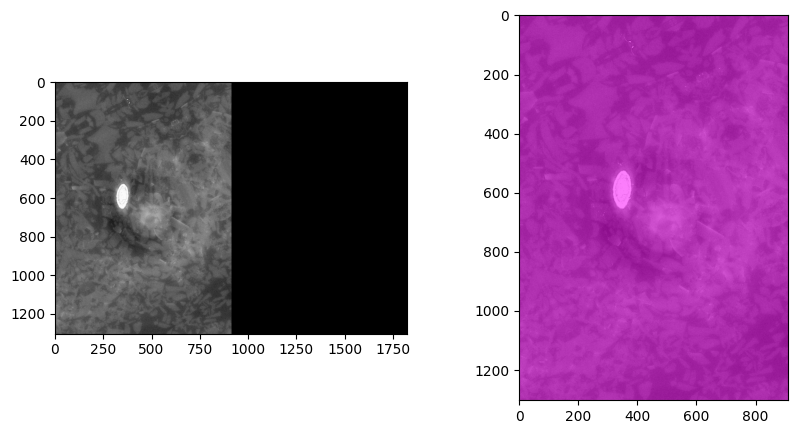

In [41]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.hstack([check_img[0].squeeze(),check_msk[0].squeeze()]),cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(check_img[0].squeeze(),cmap='gray')
plt.imshow(check_msk[0].squeeze(),cmap='spring',alpha=0.5)
plt.show()

In [42]:
valid_dl = ValidLoader(valid_meta[0])

In [43]:
print(valid_meta[0]['shape'])

(501, 1706, 1510)


In [44]:
len(valid_dl)

250

In [45]:
num = 80
check_img,check_msk = valid_dl[num]

In [46]:
print(check_img.shape,check_msk.shape)

torch.Size([2, 1, 1706, 1510]) torch.Size([2, 1, 1706, 1510])


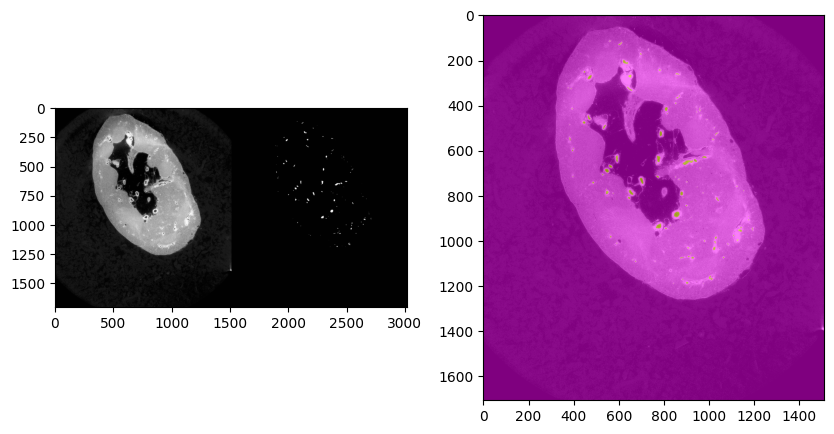

In [47]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.hstack([check_img[0].squeeze(),check_msk[0].squeeze()]),cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(check_img[0].squeeze(),cmap='gray')
plt.imshow(check_msk[0].squeeze(),cmap='spring',alpha=0.5)
plt.show()

#### Model

In [48]:
# import segmentation_models_pytorch as smp
from segmentation_models_pytorch.base.initialization import initialize_decoder
from segmentation_models_pytorch.base import modules as md

In [49]:
try:
    from inplace_abn import InPlaceABN
except ImportError:
    InPlaceABN = None


class Conv2dReLU(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        use_batchnorm=True,
    ):

        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()

        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)

        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)


class SCSEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)


class ArgMax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Clamp(nn.Module):
    def __init__(self, min=0, max=1):
        super().__init__()
        self.min, self.max = min, max

    def forward(self, x):
        return torch.clamp(x, self.min, self.max)


class Activation(nn.Module):
    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)


class Attention(nn.Module):
    def __init__(self, name, **params):
        super().__init__()

        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

In [50]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(head_channels, head_channels, use_batchnorm=use_batchnorm)
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [51]:
class SmpUnetDecoder(nn.Module):
	def __init__(self,
	         in_channel,
	         skip_channel,
	         out_channel,
	    ):
		super().__init__()
		self.center = nn.Identity()

		i_channel = [in_channel,]+ out_channel[:-1]
		s_channel = skip_channel
		o_channel = out_channel
		block = [
			DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
			for i, s, o in zip(i_channel, s_channel, o_channel)
		]
		self.block = nn.ModuleList(block)

	def forward(self, feature, skip):
		d = self.center(feature)
		decode = []
		for i, block in enumerate(self.block):
			s = skip[i]
			d = block(d, s)
			decode.append(d)

		last  = d
		return last, decode

In [52]:
def _check_reduction(reduction_factors):
    """
    Assume spatial dimensions of the features decrease by factors of two.
    For example, convnext start with stride=4 cannot be used in my code.
    """
    r_prev = 1
    for r in reduction_factors:
        if r / r_prev != 2:
            raise AssertionError('Reduction assumed to increase by 2: {}'.format(reduction_factors))
        r_prev = r

In [53]:
sys.path.append('/kaggle/input/hubmappvt2v2daformer-model/coat/')
# sys.path.append('/kaggle/input/nextvit-base-1channels-convert-trt/')
from coat import coat_parallel_small,coat_lite_small,coat_lite_medium

# from timm.models.levit import levit_256,LevitDistilled,Levit,checkpoint_filter_fn
# from timm.models._builder import build_model_with_cfg


In [54]:
class Net(nn.Module):
    def __init__(self,
#         encoder=coat_parallel_small,
#         encoder_cfg=dict(in_chans=CFG.in_chans,drop_path_rate=CFG.drop_path_rate,drop_rate=CFG.drop_rate),
                ):
        super(Net, self).__init__( )
        
#         self.cfg = cfg
#         self.training = True
#         self.encoder = create_levit('levit_256',in_chans=CFG.in_chans,drop_path_rate=CFG.drop_path_rate,
#                                     use_conv=True,
#                                     pretrained=False)
#         print(self.encoder.feature_info[-4:])
        self.encoder = eval(CFG.backbone)(in_chans=CFG.in_chans,
                                           drop_path_rate=CFG.drop_path_rate,drop_rate=CFG.drop_rate)
#         self.encoder = timm.create_model(CFG.backbone, in_chans=CFG.in_chans,features_only=False, 
#                                          pretrained=True,
#                                          drop_path_rate=CFG.drop_path_rate,
#                                          drop_rate=CFG.drop_rate)
#         self.encoder = encoder(**encoder_cfg)
#         encoder_channels = [self.encoder.feature_info[-4:][i]["num_chs"] for i in range(4)]
#         encoder_channels = [96, 256, 512, 1024]
        encoder_channels = self.encoder.embed_dims
#         _check_reduction(self.encoder.feature_info.reduction())
        conv_dim = 32
#         self.encoder.stem = nn.Sequential(
#                 nn.Conv2d(CFG.in_chans, 96, kernel_size=3, stride=2, padding=1, bias=False),
#                 nn.Conv2d(96,96, kernel_size=3, stride=1, padding=1, bias=False),
#                 nn.BatchNorm2d(96),
#             )
        
        self.conv1 = nn.Sequential(
        nn.Conv2d(CFG.in_chans, 32, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 2*conv_dim, kernel_size=3, stride=1, padding=1, bias=False)
        )

        encoder_channels = [conv_dim,2*conv_dim]+encoder_channels
        decoder_channels = CFG.decoder_channels  # (256, 128, 64, 32, 16)
        print('Encoder channels:', CFG.backbone, encoder_channels)
        print('Decoder channels:', decoder_channels)

#         assert len(encoder_channels) == len(decoder_channels)

        self.decoder =  SmpUnetDecoder(
            in_channel   = encoder_channels[-1],
            skip_channel = encoder_channels[:-1][::-1],
            out_channel  = decoder_channels,
            )

        self.segmentation_head = smp.base.SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=CFG.target_size, activation=None, kernel_size=1,
        )

        initialize_decoder(self.decoder)

#         self.last_conv = get_asym_conv(CFG.size)
        
        self.output_type = ['inference', 'loss']
#         self.rgb = RGB()

    
    def forward(self, image):
        B, C, H, W = image.shape
        h = (H//32)*32
        w = (W//32)*32
        x = image[:,:,:h,:w]
#         x = x.expand(-1, 3, -1, -1)
#         x = self.rgb(x)
        encoder = []
        x0 = self.conv1(x);encoder.append(x0)
        x0 = F.avg_pool2d(x0,kernel_size=2,stride=2)
        x0 = self.conv2(x0);encoder.append(x0)
#         x = self.encoder.stem(x)
#         print(x.shape)
#         x = F.avg_pool2d(x,kernel_size=2,stride=2)
#         features = self.encoder.forward_features(x)
#         for i in range(4):
#             x = self.encoder.stages[i](x)
#             encoder.append(x)
        features = self.encoder(x)
        encoder.extend(features)
#         [print(f'encode_{i}', e.shape) for i,e in enumerate(encoder)]
        feature = encoder[-1]
        skip = encoder[:-1][::-1]
        decoder_output, decoder = self.decoder(feature, skip)
#         [print(f'decode_{i}', e.shape) for i,e in enumerate(decoder)]
        y_pred = self.segmentation_head(decoder_output)
#         y_pred = F.interpolate(y_pred,scale_factor=2,mode='bilinear')
        y_pred = F.pad(y_pred,[0,W-w,0,H-h,0,0,0,0], mode='constant', value=0)
        # Tiny conv from y_sym_pred -> y_pred
#         y_pred = self.last_conv(y_sym_pred)
# #         print(logit.shape)
# #         if CFG.size!=256:
# #             logit = F.interpolate(logit, size=(256, 256), mode='bilinear',align_corners=False, antialias=True)
        
#         output = {}
#         if 'loss' in self.output_type:
#             output['label_loss'] = criterion(logit,msks)
# #         			output['label_loss'] = F.binary_cross_entropy_with_logits(logit.squeeze(1), msks)
# #                     output['label_loss'] = criterion_binary_cross_entropy(logit, batch['mask'])

# #         			for i in range(len(self.aux)):
# #         				output['aux%d_loss' % i] = criterion_aux_loss(self.aux[i](encoder[i]), msks)

#         if 'inference' in self.output_type:
#                         #probability_from_logit = torch.softmax(logit,1)
#             probability_from_logit = torch.sigmoid(logit)
#             # 			output['probability_from_logit'] = probability_from_logit
#             output['probability'] = probability_from_logit

        return y_pred

In [55]:
def adapt_input_conv(in_chans, conv_weight):
    conv_type = conv_weight.dtype
    conv_weight = conv_weight.float()  # Some weights are in torch.half, ensure it's float for sum on CPU
    O, I, J, K = conv_weight.shape
    if in_chans == 1:
        if I > 3:
            assert conv_weight.shape[1] % 3 == 0
            # For models with space2depth stems
            conv_weight = conv_weight.reshape(O, I // 3, 3, J, K)
            conv_weight = conv_weight.sum(dim=2, keepdim=False)
        else:
            conv_weight = conv_weight.sum(dim=1, keepdim=True)
    elif in_chans != 3:
        if I != 3:
            raise NotImplementedError('Weight format not supported by conversion.')
        else:
            # NOTE this strategy should be better than random init, but there could be other combinations of
            # the original RGB input layer weights that'd work better for specific cases.
            repeat = int(math.ceil(in_chans / 3))
            conv_weight = conv_weight.repeat(1, repeat, 1, 1)[:, :in_chans, :, :]
            conv_weight *= (3 / float(in_chans))
    conv_weight = conv_weight.to(conv_type)
    return conv_weight

In [56]:
pvt_url = {
    'pvt_v2_b0': 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b0.pth',
    'pvt_v2_b1': 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b1.pth',
    'pvt_v2_b2': 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b2.pth',
    'pvt_v2_b3': 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b3.pth',
    'pvt_v2_b4': 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b4.pth',
    'pvt_v2_b5': 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b5.pth',
    'pvt_v2_b2_li': 'https://github.com/whai362/PVT/releases/download/v2/pvt_v2_b2_li.pth',
    'timm/coatnet_rmlp_2_rw_384.sw_in12k_ft_in1k':'https://huggingface.co/timm/coatnet_rmlp_2_rw_384.sw_in12k_ft_in1k/blob/main/pytorch_model.bin',
    'coat_small.in1k' :'https://vcl.ucsd.edu/coat/pretrained/coat_small_7479cf9b.pth',
    'coat_lite_small':'https://vcl.ucsd.edu/coat/pretrained/coat_lite_small_8d362f48.pth',
    'coat_lite_medium':'https://vcl.ucsd.edu/coat/pretrained/coat_lite_medium_384x384_f9129688.pth',
}

In [57]:
# import segmentation_models_pytorch as smp
from torch.hub import load_state_dict_from_url

def build_model(pretrain=False):
#     encoder = pvt_v2_b4(in_chans=CFG.in_chans)
#     checkpoint = './pvt_v2_b4.pth'
#     checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)
#     state_dict = checkpoint
#     encoder.load_state_dict(state_dict,strict=False)
    
    model = Net()
    if pretrain==True:
        pretrained_loc = pvt_url[CFG.backbone]
        state_dict = load_state_dict_from_url(
                pretrained_loc, map_location='cpu', progress=True, check_hash=True)
        if 'model' in state_dict:
            state_dict['model']['patch_embed1.proj.weight'] = adapt_input_conv(CFG.in_chans, state_dict ['model']['patch_embed1.proj.weight'])
            model.encoder.load_state_dict(state_dict['model'],strict=False)
        else:
            state_dict['patch_embed1.proj.weight'] = adapt_input_conv(CFG.in_chans, state_dict['patch_embed1.proj.weight'])
            model.encoder.load_state_dict(state_dict, strict=False)
    model.to(CFG.device)
    model = nn.DataParallel(model)
    return model

def load_model(model,ckpt_path):

    f = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    if 'model' in f:
        model.load_state_dict(f['model'],strict=True)
    else:
        model.load_state_dict(f, strict=True) 
    model.eval()
    print(f'Loaded weights from {ckpt_path}!')
    return model

In [58]:
def run_check_net():
    height, width = 512, 1125
    batch_size = CFG.train_batch_size

    image = torch.from_numpy(np.random.uniform(0, 1, (batch_size, 1, height, width))).float()#.cuda()

#     net = Net()
    net = build_model(False)
    #print(net)

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            mask = net(image)

    print('image', image.shape)
    print('mask', mask.shape)

In [59]:
run_check_net()

Encoder channels: coat_lite_small [32, 64, 64, 128, 320, 512]
Decoder channels: [512, 256, 128, 64, 32]
image torch.Size([2, 1, 512, 1125])
mask torch.Size([2, 1, 512, 1125])


In [60]:
#  class GradualWarmupSchedulerV2(GradualWarmupScheduler):
#     """
#     https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
#     """
#     def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
#         super(GradualWarmupSchedulerV2, self).__init__(
#             optimizer, multiplier, total_epoch, after_scheduler)

#     def get_lr(self):
#         if self.last_epoch > self.total_epoch:
#             if self.after_scheduler:
#                 if not self.finished:
#                     self.after_scheduler.base_lrs = [
#                         base_lr * self.multiplier for base_lr in self.base_lrs]
#                     self.finished = True
#                 return self.after_scheduler.get_lr()
#             return [base_lr * self.multiplier for base_lr in self.base_lrs]
#         if self.multiplier == 1.0:
#             return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
#         else:
#             return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)

    
def fetch_scheduler(optimizer, cfg=CFG, spe=None):
    if cfg.LR_SCHEDULER == "CosineAnnealingLR":
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=cfg.T_max, eta_min=cfg.min_lr
        )
    elif CFG.LR_SCHEDULER == "CosineAnnealingWarmRestarts":
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=cfg.T_mult, eta_min=cfg.min_lr
        )
    elif cfg.LR_SCHEDULER == "ReduceLROnPlateau":
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="max",
            factor=0.95,
            patience=2,
            threshold=0.0001,
            min_lr=cfg.min_lr,
        )
    elif cfg.LR_SCHEDULER == "ExponentialLR":
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif cfg.LR_SCHEDULER == "OneCycleLR":
        scheduler = lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=cfg.max_lr,
            steps_per_epoch=spe,
            epochs=cfg.epochs,
            #                   'total_steps':500,
            pct_start=0.05,
            div_factor=25.,
            final_div_factor=2500.0,
        )
    elif cfg.LR_SCHEDULER == "get_cosine_schedule_with_warmup":
        scheduler = transformers.get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=spe * cfg.epochs * 0.2,
            num_training_steps=spe * cfg.epochs,
        )
    elif cfg.scheduler == None:
        return None

    return scheduler

In [61]:
class BoundaryDoULoss(nn.Module):
    def __init__(self, n_classes):
        super(BoundaryDoULoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _adaptive_size(self, score, target):
        kernel = torch.Tensor([[0,1,0], [1,1,1], [0,1,0]])
        padding_out = torch.zeros((target.shape[0], target.shape[-2]+2, target.shape[-1]+2))
        padding_out[:, 1:-1, 1:-1] = target
        h, w = 3, 3

        Y = torch.zeros((padding_out.shape[0], padding_out.shape[1] - h + 1, padding_out.shape[2] - w + 1)).cuda()
        for i in range(Y.shape[0]):
            Y[i, :, :] = torch.conv2d(target[i].unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0).cuda(), padding=1)
        Y = Y * target
        Y[Y == 5] = 0
        C = torch.count_nonzero(Y)
        S = torch.count_nonzero(target)
        smooth = 1e-5
        alpha = 1 - (C + smooth) / (S + smooth)
        alpha = 2 * alpha - 1

        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        alpha = min(alpha, 0.8)  ## We recommend using a truncated alpha of 0.8, as using truncation gives better results on some datasets and has rarely effect on others.
        loss = (z_sum + y_sum - 2 * intersect + smooth) / (z_sum + y_sum - (1 + alpha) * intersect + smooth)

        return loss

    def forward(self, inputs, target):
        if self.n_classes == 1:
            inputs = torch.sigmoid(inputs)
        else:
            inputs = torch.softmax(inputs, dim=1)
            target = self._one_hot_encoder(target)
           
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())

        loss = 0.0
        for i in range(0, self.n_classes):
            loss += self._adaptive_size(inputs[:, i], target[:, i])
        return loss / self.n_classes

In [62]:
DiceLoss = smp.losses.DiceLoss(mode='binary',smooth=CFG.smooth)
BCELoss = smp.losses.SoftBCEWithLogitsLoss(pos_weight=torch.tensor(10.))
MCCLoss = smp.losses.MCCLoss()
boundary_dou_loss = BoundaryDoULoss(CFG.target_size)

alpha = 0.7
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return 0.4 * BCELoss(y_pred, y_true) + 0.6 * boundary_dou_loss(y_pred, y_true)
#     return 0.6 * BCELoss(y_pred, y_true) + 0.4 * DiceLoss(y_pred, y_true)
#     return 0.6 * BCELoss(y_pred, y_true) + 0.4 * MCCLoss(y_pred, y_true)
#     return DiceLoss(y_pred, y_true)
#     return BCELoss(y_pred, y_true)

"""
Loss: criterion = BCEWithLogitsLoss()

if augmented:  # w = 0
  # Always train y_sym
  loss = criterion(y_sym_pred, y_sym)  
else:  # w = 1
  # Also train y when no augmentation (random probability 0.05)
  # Augmentation cannot be applied to y due to lack of symmetry
  loss = criterion(y_sym_pred, y_sym) + criterion(y_pred, y)
"""

# from torch.nn.modules.loss import _Loss

# class BCELoss(_Loss):
#     def __init__(self):
#         super().__init__()
#         self.criterion = nn.BCEWithLogitsLoss(reduction='none')

#     def forward(self,
#                 y_sym_pred: torch.Tensor, y_sym: torch.Tensor,
#                 y_pred: torch.Tensor, y: torch.Tensor, w) -> torch.Tensor:
#         loss_sym = self.criterion(y_sym_pred, y_sym).mean(dim=(1, 2, 3))
#         loss_original = self.criterion(y_pred, y).mean(dim=(1, 2, 3))
#         loss = loss_sym + w * loss_original

#         return loss.mean()  # mean of batch

'\nLoss: criterion = BCEWithLogitsLoss()\n\nif augmented:  # w = 0\n  # Always train y_sym\n  loss = criterion(y_sym_pred, y_sym)  \nelse:  # w = 1\n  # Also train y when no augmentation (random probability 0.05)\n  # Augmentation cannot be applied to y due to lack of symmetry\n  loss = criterion(y_sym_pred, y_sym) + criterion(y_pred, y)\n'

In [63]:
model = build_model(True)
# model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
# optimizer = create_optimizer_v2(
#         model.parameters(), opt="lookahead_radam", lr=CFG.lr
#     )
# scheduler = get_scheduler(CFG, optimizer)
steps_per_epoch = len(train_dl)
# CFG.T_max = (CFG.epochs-int(0.75*CFG.epochs))*steps_per_epoch
# CFG.T_0 = (CFG.epochs-int(0.75*CFG.epochs))*steps_per_epoch
scheduler = fetch_scheduler(optimizer, cfg=CFG, spe=steps_per_epoch)

Encoder channels: coat_lite_small [32, 64, 64, 128, 320, 512]
Decoder channels: [512, 256, 128, 64, 32]


Downloading: "https://vcl.ucsd.edu/coat/pretrained/coat_lite_small_8d362f48.pth" to /root/.cache/torch/hub/checkpoints/coat_lite_small_8d362f48.pth
100%|██████████| 303M/303M [00:07<00:00, 40.6MB/s]


In [64]:
class dotdict(dict):
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

	def __getattr__(self, name):
		try:
			return self[name]
		except KeyError:
			raise AttributeError(name)

def time_to_str(t, mode='min'):
	if mode=='min':
		t  = int(t)/60
		hr = t//60
		min = t%60
		return '%2d hr %02d min'%(hr,min)

	elif mode=='sec':
		t   = int(t)
		min = t//60
		sec = t%60
		return '%2d min %02d sec'%(min,sec)

	else:
		raise NotImplementedError


def image_show_norm(name, image, min=None, max=None, type='bgr', resize=1):
	if max is None: max = image.max()
	if min is None: min = image.min()
	if type == 'rgb': image = np.ascontiguousarray(image[:, :, ::-1])

	H, W = image.shape[0:2]
	cv2.namedWindow(name, cv2.WINDOW_GUI_NORMAL)  # WINDOW_NORMAL
	cv2.imshow(name, (np.clip((image - min) / (max - min), 0, 1) * 255).astype(np.uint8))
	cv2.resizeWindow(name, round(resize * W), round(resize * H))

################################################################################################
def np_hit_fp_metric(predict, truth):
    p = (predict > 0.5)
    t = (truth > 0.5)
    hit = (p * t).sum()
    fp = (p * (1 - t)).sum()
    t_sum = t.sum()
    p_sum = p.sum()

    #print('hit', hit/t_sum)
    #print('fp', fp/p_sum)
    return hit, fp, t_sum, p_sum


# _NEIGHBOUR_CODE_TO_NORMALS is a lookup table.
# For every binary neighbour code
# (2x2x2 neighbourhood = 8 neighbours = 8 bits = 256 codes)
# it contains the surface normals of the triangles (called "surfel" for
# "surface element" in the following). The length of the normal
# vector encodes the surfel area.
#
# created using the marching_cube algorithm
# see e.g. https://en.wikipedia.org/wiki/Marching_cubes
# pylint: disable=line-too-long
_NEIGHBOUR_CODE_TO_NORMALS = [[[0, 0, 0]], [[0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]], [[-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]], [[0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[0.125, -0.125, -0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0, 0, 0]]]

def create_table_neighbour_code_to_surface_area(spacing_mm):
    """Returns an array mapping neighbourhood code to the surface elements area.

  Note that the normals encode the initial surface area. This function computes
  the area corresponding to the given `spacing_mm`.

  Args:
    spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2
      direction.
  """
    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(_NEIGHBOUR_CODE_TO_NORMALS[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    return neighbour_code_to_surface_area

def compute_area(y: list, unfold: nn.Unfold, area: torch.Tensor, device) -> torch.Tensor:
    """
    Args:
      y (list[Tensor]): A pair of consecutive slices of mask
      unfold: nn.Unfold(kernel_size=(2, 2), padding=1)
      area (Tensor): surface area for 256 patterns (256, )

    Returns:
      Surface area of surface in 2x2x2 cube
    """
    # Two layers of segmentation masks -> (2, H, W)
    yy = torch.stack(y, dim=0).to(torch.float16)  # bit (0/1) but unfold requires float

    # unfold slides through the volume like a convolution
    # 2x2 kernel returns 8 values (2 channels * 2x2)
    cubes_float = unfold(yy)  # (8, n_cubes)

    # Each of the 8 values are either 0 or 1
    # Convert those 8 bits to one uint8
    # but indices are required to be int32 or long for area[cube_byte] below, not uint8
    cubes_byte = torch.zeros(cubes_float.size(1), dtype=torch.int32, device=device)

    for k in range(8):
        cubes_byte += cubes_float[k, :].to(torch.int32) << k

    # Area is defined for each of 256 bit patterns
    cubes_area = area[cubes_byte]

    return cubes_area

def fast_compute_surface_dice_score_from_tensor(
	predict,  #np.uint8 (0,1 values)
	truth,
	**kwargs
) -> float:
	device = torch.device('cuda')

	n_slices,h,w = predict.shape


	# 256 patterns of area: Tensor (256, )
	area = create_table_neighbour_code_to_surface_area((1, 1, 1))
	area = torch.from_numpy(area).to(device)  # torch.float32

	# Slide through the volume like a convolution
	unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)


	# Padding before first slice
	y0 = y0_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

	num = 0     # numerator of surface Dice
	denom = 0   # denominator
	for i in range(n_slices + 1):
		if i < n_slices:
			y1 = truth[i]
			y1 = y1.to(device)
			y1_pred = predict[i]
			y1_pred = y1_pred.to(device)
		else:
			# Padding after the last slice
			y1 = y1_pred = torch.zeros((h, w), dtype=torch.uint8, device=device)

		area_pred = compute_area([y0_pred, y1_pred], unfold, area, device)
		area_true = compute_area([y0, y1], unfold, area, device)

		idx = torch.logical_and(area_pred > 0, area_true > 0)

		num += area_pred[idx].sum() + area_true[idx].sum()
		denom += area_pred.sum() + area_true.sum()

		# Next slice
		y0 = y1
		y0_pred = y1_pred

	dice = num / denom.clamp(min=1e-8)
	return dice.item()

In [65]:
def train_fn(train_loader, model, criterion, optimizer,scheduler, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_pred = model(images)
#             y_pred = torch.nan_to_num(y_pred, nan=0, posinf=1, neginf=0)
            loss = criterion(y_pred, labels)
#             loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        optimizer.zero_grad()
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        torch.cuda.empty_cache()
        gc.collect()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
#     mask_pred = np.zeros(valid_mask_gt.shape)
#     mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()
#     val_preds = []
#     val_labels= []
    tp = 0
    fp = 0
    fn = 0
    positives_pred = 0
    positives_true = 0
    surface_dice = 0.
    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        batch_size = images.size(0)
        labels = labels.to(device)

        with torch.no_grad():
            with autocast(CFG.use_amp):
                y_pred  = model(images)
                y_pred = torch.nan_to_num(y_pred, nan=0, posinf=1, neginf=0)
                loss = criterion(y_pred, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
#         y_preds = outputs['probability']
#         y_preds = y_preds.to('cpu').cpu().numpy()
#         start_idx = step*CFG.valid_batch_size
#         end_idx = start_idx + batch_size
#         for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
#             mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
#             mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))
#         val_preds.append(y_preds)
#         val_labels.append(labels)
        y_pred = (y_pred.sigmoid() > CFG.TH)
        tp += (y_pred * labels).sum().item()
#         fn += ((~y_pred) * (~labels.int())).sum().item()
        fp += (y_pred > labels).sum().item()
        positives_pred += y_pred.sum().item()
        positives_true += labels.sum().item()
        surface_dice +=fast_compute_surface_dice_score_from_tensor(y_pred.squeeze(),labels.squeeze())
#         print(val_dice.shape)
#         val_scores.append(val_dice)
        torch.cuda.empty_cache()
        gc.collect()
#     val_preds = torch.cat(val_preds,dim=0)
#     val_labels = torch.cat(val_labels,dim=0)
#     val_dice = dice(val_preds, val_labels.long())
    global_dice = (2 * tp + 1e-5) / (positives_pred + positives_true + 1e-5)
    global_fpr = (fp + 1e-5) / (positives_true + 1e-5)
    global_recall = (tp + 1e-5) / (positives_true + 1e-5)
    global_surface_dice = surface_dice / (step+1)
#     print(f'mask_count_min: {mask_count.min()}')
#     mask_pred /= mask_count
    return losses.avg, global_dice, global_fpr, global_recall, global_surface_dice

In [66]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

def dice_coef(y_true, y_pred, thr=0.5, dim=(1,2), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(1,2), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon))
    return iou

In [67]:
fold = CFG.fold

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf
criterion = criterion

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train

    avg_loss = train_fn(train_dl, model, criterion, optimizer,scheduler, CFG.device)

    # eval
    avg_val_loss, best_dice, fp_score, recall, surface_dice = valid_fn(
        valid_dl, model, criterion, CFG.device)

#     scheduler_step(scheduler, avg_val_loss, epoch)

#     best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = surface_dice
#     fp_score = best_fp
    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgDiceScore: {best_dice:4f} avgSurfaceScore: {score:.4f} FPScore: {fp_score:.6f} Recall: {recall:.6f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < fp_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best surface Score: {best_score:.4f} Model')
#         Logger.info(
#             f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict()},
#                     'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
    if epoch==0:
        best_fp = 1000
    elif epoch>=4 and fp_score < best_fp:
        best_fp = fp_score
        Logger.info(
            f'Epoch {epoch+1} - Save Epoch {epoch} FP Score: {best_fp:.6f} Model') 
        torch.save({'model': model.state_dict()},
#                     'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_EP{epoch}_fp{fp_score:.4f}.pth')
    if epoch==CFG.epochs-1:
        torch.save({'model': model.state_dict()},
#                     'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
#     del mask_pred
    torch.cuda.empty_cache()
    gc.collect()

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 - avg_train_loss: 0.7410  avg_val_loss: 0.7143  time: 882s
Epoch 1 - avgDiceScore: 0.540727 avgSurfaceScore: 0.4238 FPScore: 1.649782 Recall: 0.981865
Epoch 1 - Save Best surface Score: 0.4238 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 - avg_train_loss: 0.6681  avg_val_loss: 0.6652  time: 897s
Epoch 2 - avgDiceScore: 0.746262 avgSurfaceScore: 0.6410 FPScore: 0.637517 Recall: 0.974699
Epoch 2 - Save Best surface Score: 0.6410 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3 - avg_train_loss: 0.6173  avg_val_loss: 0.6213  time: 878s
Epoch 3 - avgDiceScore: 0.711337 avgSurfaceScore: 0.6805 FPScore: 0.753707 Recall: 0.968039
Epoch 3 - Save Best surface Score: 0.6805 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4 - avg_train_loss: 0.5680  avg_val_loss: 0.5718  time: 874s
Epoch 4 - avgDiceScore: 0.893762 avgSurfaceScore: 0.7835 FPScore: 0.188327 Recall: 0.960085
Epoch 4 - Save Best surface Score: 0.7835 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5 - avg_train_loss: 0.5212  avg_val_loss: 0.5247  time: 887s
Epoch 5 - avgDiceScore: 0.899999 avgSurfaceScore: 0.8024 FPScore: 0.163162 Recall: 0.951676
Epoch 5 - Save Best surface Score: 0.8024 Model
Epoch 5 - Save Epoch 4 FP Score: 0.163162 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6 - avg_train_loss: 0.4889  avg_val_loss: 0.4834  time: 890s
Epoch 6 - avgDiceScore: 0.902786 avgSurfaceScore: 0.7978 FPScore: 0.187985 Recall: 0.977471


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7 - avg_train_loss: 0.4625  avg_val_loss: 0.4619  time: 872s
Epoch 7 - avgDiceScore: 0.907061 avgSurfaceScore: 0.8060 FPScore: 0.137122 Recall: 0.943730
Epoch 7 - Save Best surface Score: 0.8060 Model
Epoch 7 - Save Epoch 6 FP Score: 0.137122 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8 - avg_train_loss: 0.4526  avg_val_loss: 0.4527  time: 886s
Epoch 8 - avgDiceScore: 0.888755 avgSurfaceScore: 0.7884 FPScore: 0.148852 Recall: 0.918833


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9 - avg_train_loss: 0.4530  avg_val_loss: 0.4331  time: 903s
Epoch 9 - avgDiceScore: 0.896412 avgSurfaceScore: 0.8037 FPScore: 0.195212 Recall: 0.970836


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10 - avg_train_loss: 0.4446  avg_val_loss: 0.4379  time: 893s
Epoch 10 - avgDiceScore: 0.902919 avgSurfaceScore: 0.8065 FPScore: 0.130008 Recall: 0.930018
Epoch 10 - Save Best surface Score: 0.8065 Model
Epoch 10 - Save Epoch 9 FP Score: 0.130008 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11 - avg_train_loss: 0.4396  avg_val_loss: 0.4330  time: 889s
Epoch 11 - avgDiceScore: 0.879779 avgSurfaceScore: 0.7706 FPScore: 0.220170 Recall: 0.958276


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12 - avg_train_loss: 0.4420  avg_val_loss: 0.4250  time: 873s
Epoch 12 - avgDiceScore: 0.920584 avgSurfaceScore: 0.8113 FPScore: 0.113988 Recall: 0.950069
Epoch 12 - Save Best surface Score: 0.8113 Model
Epoch 12 - Save Epoch 11 FP Score: 0.113988 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13 - avg_train_loss: 0.4419  avg_val_loss: 0.4297  time: 889s
Epoch 13 - avgDiceScore: 0.918699 avgSurfaceScore: 0.7995 FPScore: 0.104220 Recall: 0.938171
Epoch 13 - Save Epoch 12 FP Score: 0.104220 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14 - avg_train_loss: 0.4399  avg_val_loss: 0.4224  time: 885s
Epoch 14 - avgDiceScore: 0.927289 avgSurfaceScore: 0.8398 FPScore: 0.099696 Recall: 0.950615
Epoch 14 - Save Best surface Score: 0.8398 Model
Epoch 14 - Save Epoch 13 FP Score: 0.099696 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15 - avg_train_loss: 0.4237  avg_val_loss: 0.4297  time: 908s
Epoch 15 - avgDiceScore: 0.893511 avgSurfaceScore: 0.8101 FPScore: 0.175063 Recall: 0.948885


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16 - avg_train_loss: 0.4302  avg_val_loss: 0.4246  time: 901s
Epoch 16 - avgDiceScore: 0.910183 avgSurfaceScore: 0.8286 FPScore: 0.146059 Recall: 0.957155


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17 - avg_train_loss: 0.4420  avg_val_loss: 0.4209  time: 867s
Epoch 17 - avgDiceScore: 0.932491 avgSurfaceScore: 0.8307 FPScore: 0.091003 Recall: 0.953012
Epoch 17 - Save Epoch 16 FP Score: 0.091003 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18 - avg_train_loss: 0.4335  avg_val_loss: 0.4244  time: 896s
Epoch 18 - avgDiceScore: 0.894645 avgSurfaceScore: 0.7998 FPScore: 0.182069 Recall: 0.956736


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19 - avg_train_loss: 0.4311  avg_val_loss: 0.4220  time: 888s
Epoch 19 - avgDiceScore: 0.928428 avgSurfaceScore: 0.8237 FPScore: 0.092253 Recall: 0.946347


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20 - avg_train_loss: 0.4290  avg_val_loss: 0.4205  time: 897s
Epoch 20 - avgDiceScore: 0.930355 avgSurfaceScore: 0.8358 FPScore: 0.092796 Recall: 0.950492


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21 - avg_train_loss: 0.4374  avg_val_loss: 0.4202  time: 889s
Epoch 21 - avgDiceScore: 0.924748 avgSurfaceScore: 0.8336 FPScore: 0.117330 Recall: 0.960936


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22 - avg_train_loss: 0.4399  avg_val_loss: 0.4229  time: 883s
Epoch 22 - avgDiceScore: 0.934278 avgSurfaceScore: 0.8448 FPScore: 0.058130 Recall: 0.927622
Epoch 22 - Save Best surface Score: 0.8448 Model
Epoch 22 - Save Epoch 21 FP Score: 0.058130 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23 - avg_train_loss: 0.4393  avg_val_loss: 0.4233  time: 891s
Epoch 23 - avgDiceScore: 0.921519 avgSurfaceScore: 0.8219 FPScore: 0.107916 Recall: 0.946670


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24 - avg_train_loss: 0.4320  avg_val_loss: 0.4217  time: 892s
Epoch 24 - avgDiceScore: 0.935893 avgSurfaceScore: 0.8467 FPScore: 0.058193 Recall: 0.930693
Epoch 24 - Save Best surface Score: 0.8467 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25 - avg_train_loss: 0.4292  avg_val_loss: 0.4235  time: 896s
Epoch 25 - avgDiceScore: 0.929666 avgSurfaceScore: 0.8422 FPScore: 0.068807 Recall: 0.928340


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 26 - avg_train_loss: 0.4296  avg_val_loss: 0.4193  time: 890s
Epoch 26 - avgDiceScore: 0.939362 avgSurfaceScore: 0.8517 FPScore: 0.063010 Recall: 0.941463
Epoch 26 - Save Best surface Score: 0.8517 Model


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27 - avg_train_loss: 0.4321  avg_val_loss: 0.4214  time: 899s
Epoch 27 - avgDiceScore: 0.935248 avgSurfaceScore: 0.8381 FPScore: 0.061577 Recall: 0.932458


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 28 - avg_train_loss: 0.4299  avg_val_loss: 0.4187  time: 881s
Epoch 28 - avgDiceScore: 0.935129 avgSurfaceScore: 0.8446 FPScore: 0.085650 Recall: 0.953376


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29 - avg_train_loss: 0.4284  avg_val_loss: 0.4252  time: 881s
Epoch 29 - avgDiceScore: 0.927566 avgSurfaceScore: 0.8414 FPScore: 0.058828 Recall: 0.915798


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 30 - avg_train_loss: 0.4301  avg_val_loss: 0.4242  time: 898s
Epoch 30 - avgDiceScore: 0.927222 avgSurfaceScore: 0.8421 FPScore: 0.065888 Recall: 0.921267


In [68]:
!rm -rf /kaggle/working/einops